In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 12a

### Using artificial data

## Sequential Modeling Regression
<img src='../../prasami_images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [6]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf

In [7]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 100

BATCH_SIZE = 64
# Set parameters for decoration of plots
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [8]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Helper Function

In [9]:
###-----------------------------------
### Function to plot Loss Curve
###-----------------------------------

def fn_plot_tf_hist(hist_df : pd.DataFrame):
    '''
    Args:
      hist_df : pandas Dataframe with four columns
                For 'x' values, we will use index
    '''
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    
    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y3] == hist_df[y3].min()]
    
    ax = axes[0]

    hist_df.plot(y = [y1,y3], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot
    
    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y3].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.set_title('Errors')
    ax.grid()
    
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y2, y4], ax = ax, colormap=CMAP)
    
    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy()-1, best[y4].to_numpy()[0]), # location of text 
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow
    
    
    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y2.capitalize())
    ax.grid()
    ax.legend(loc = 'lower left')
    
    plt.tight_layout()

## Create Some Regression data

In [10]:
start = -2.1
end = 2.1

### Training data

delta = 0.0005

X_train = np.arange(start, end+ delta,delta)
y_rnd = np.random.rand(X_train.shape[0]) - 0.5
y_true =   2* np.square(X_train) + 2 * np.sin(np.pi*X_train)
y_train = y_true + y_rnd* 2

### Test data
X_test = np.arange(start, end+ delta, delta * 10 )
y_rnd = np.random.rand(X_test.shape[0])- 0.5
y_true_test =   2* np.square(X_test) + 2 * np.sin(np.pi*X_test)
y_test = y_true_test  + y_rnd* 2

In [11]:
X_train.shape

(8401,)

In [12]:
8401/64

131.265625

In [13]:
num_examples = BATCH_SIZE * 131

X_train = X_train[:num_examples]
y_train = y_train[:num_examples]
y_true = y_true[:num_examples]

In [14]:
X_train.shape

(8384,)

In [15]:
X_train.max(), X_test.max()

(2.0915000000013992, 2.0999999999999104)

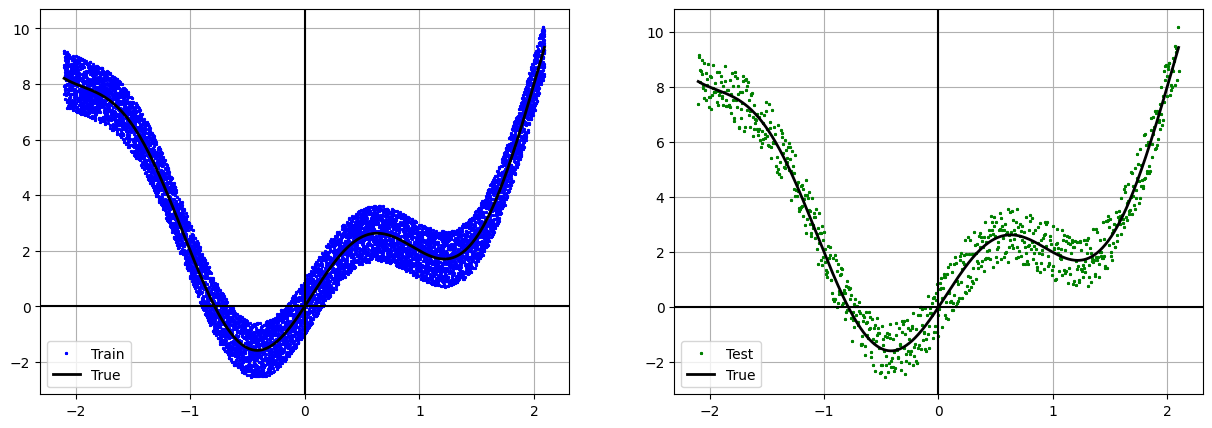

In [16]:
start = -2
end = 2
delta_train = 0.01

fig, axes = plt.subplots(1, 2, figsize =(15,5))

ax = axes[0]
ax.plot(X_train, y_train, 'b*', markersize=2, label = 'Train')
ax.plot(X_train,  y_true, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(X_test, y_test, 'g*', markersize=2, label = 'Test')
ax.plot(X_test,  y_true_test, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend();

In [17]:
# What shape of Input layer?
num_features = 1

#initializer = tf.keras.initializers.HeNormal(seed = RANDOM_STATE)

# Define Model

# Define the input layer
input_layer = tf.keras.layers.Input(shape=(1,))  # Assuming input shape is (784,)

# Add a hidden layer with 128 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)

# Add another hidden layer with 64 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(64, activation='relu')(hidden_layer)

# Add the output layer with 10 neurons (for a classification task) and softmax activation
output_layer = tf.keras.layers.Dense(1)(hidden_layer)

# Create the model by specifying the input and output layers
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# https://www.tensorflow.org/guide/keras/functional_api

# sklearn documentation

# tensorflow documentation

In [18]:
# Compile the model with a specific optimizer, loss function, and metrics

model.compile(optimizer='adam', 
              loss='mean_squared_error', 
              metrics=['mae'])

In [19]:
# fit the model
history = model.fit(X_train, y_train, 
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    epochs=EPOCHS, 
                    verbose=2)

Epoch 1/100
131/131 - 1s - loss: 6.0079 - mae: 1.8848 - val_loss: 2.7078 - val_mae: 1.3614 - 1s/epoch - 9ms/step
Epoch 2/100
131/131 - 0s - loss: 1.8910 - mae: 1.1151 - val_loss: 1.2798 - val_mae: 0.8790 - 366ms/epoch - 3ms/step
Epoch 3/100
131/131 - 0s - loss: 1.1760 - mae: 0.8487 - val_loss: 1.1257 - val_mae: 0.8291 - 363ms/epoch - 3ms/step
Epoch 4/100
131/131 - 0s - loss: 1.0643 - mae: 0.8077 - val_loss: 1.0023 - val_mae: 0.7877 - 385ms/epoch - 3ms/step
Epoch 5/100
131/131 - 0s - loss: 0.9383 - mae: 0.7649 - val_loss: 0.8726 - val_mae: 0.7477 - 388ms/epoch - 3ms/step
Epoch 6/100
131/131 - 0s - loss: 0.8015 - mae: 0.7167 - val_loss: 0.7309 - val_mae: 0.6871 - 367ms/epoch - 3ms/step
Epoch 7/100
131/131 - 0s - loss: 0.6727 - mae: 0.6623 - val_loss: 0.6435 - val_mae: 0.6603 - 369ms/epoch - 3ms/step
Epoch 8/100
131/131 - 0s - loss: 0.5632 - mae: 0.6128 - val_loss: 0.5179 - val_mae: 0.5965 - 350ms/epoch - 3ms/step
Epoch 9/100
131/131 - 0s - loss: 0.4773 - mae: 0.5719 - val_loss: 0.4451 - 

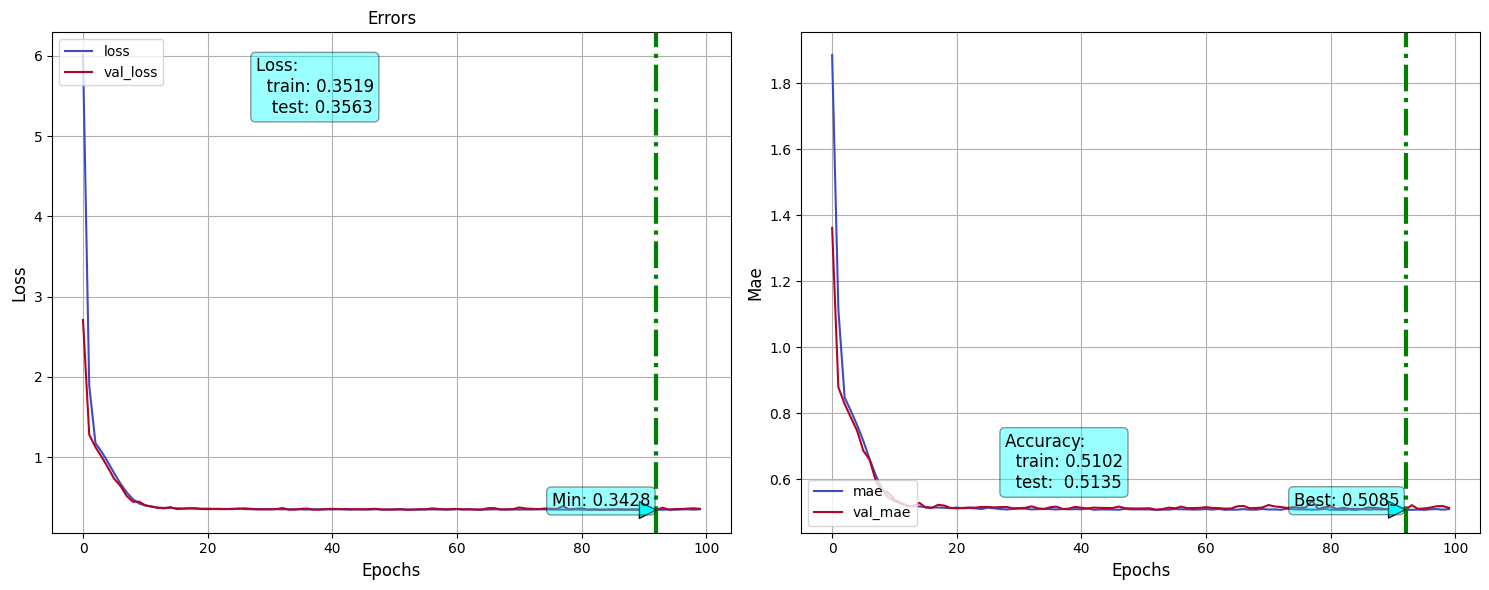

In [20]:
hist_df = pd.DataFrame(history.history)

fn_plot_tf_hist(hist_df)

In [21]:
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {error[0]:.3f}, MAE: {np.sqrt(error[1]):.3f}')

Loss: 0.356, MAE: 0.717


In [22]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'pred' : y_pred[:,0], 'test' : y_test} )

results_df['y_true'] = y_true_test

27/27 [==============================] - 0s 1ms/step


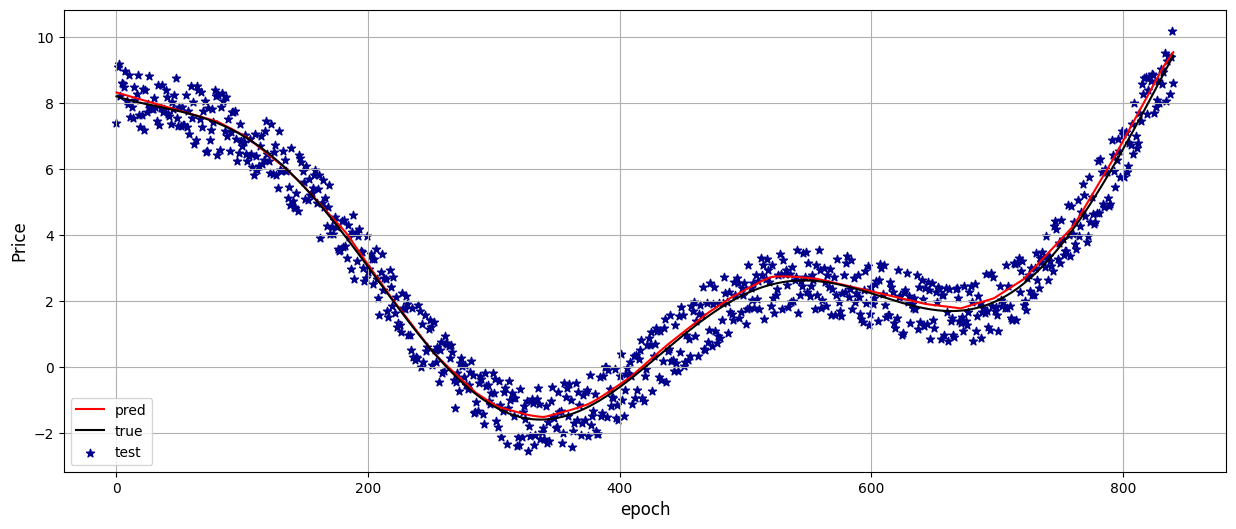

In [23]:
ax = results_df.pred.plot(c = 'r', label = 'pred');
results_df.y_true.plot(c = 'k', ax = ax, label = 'true')

plt.scatter(results_df.index, results_df.test, c='DarkBlue', marker ='*', label = 'test');
ax.set_xlabel("epoch")
ax.set_ylabel("Price")
ax.grid()
plt.legend()
plt.show()

In [24]:
# What shape of Input layer?
num_features = 1

initializer = tf.keras.initializers.HeNormal(seed = RANDOM_STATE)

# define model
model = tf.keras.Sequential()

model.add( tf.keras.layers.Dense(128, 
                                 activation='swish', 
                                 kernel_initializer=initializer, 
                                 input_shape=(num_features,)))

model.add(tf.keras.layers.Dense(64, 
                                activation='swish', 
                                kernel_initializer=initializer))

model.add(tf.keras.layers.Dense(1))

In [25]:
# compile the model
model.compile(optimizer='adam', loss='mse')

In [26]:
# fit the model
history = model.fit(X_train, y_train, 
          batch_size = BATCH_SIZE,
          validation_data=[X_test, y_test],
          epochs=EPOCHS, 
          verbose=2)

Epoch 1/100
131/131 - 1s - loss: 1.6898 - val_loss: 0.9782 - 1s/epoch - 9ms/step
Epoch 2/100
131/131 - 0s - loss: 0.8480 - val_loss: 0.7205 - 450ms/epoch - 3ms/step
Epoch 3/100
131/131 - 0s - loss: 0.6902 - val_loss: 0.6350 - 439ms/epoch - 3ms/step
Epoch 4/100
131/131 - 0s - loss: 0.6175 - val_loss: 0.5804 - 418ms/epoch - 3ms/step
Epoch 5/100
131/131 - 0s - loss: 0.5178 - val_loss: 0.4908 - 470ms/epoch - 4ms/step
Epoch 6/100
131/131 - 0s - loss: 0.4734 - val_loss: 0.4274 - 453ms/epoch - 3ms/step
Epoch 7/100
131/131 - 0s - loss: 0.4207 - val_loss: 0.4266 - 473ms/epoch - 4ms/step
Epoch 8/100
131/131 - 0s - loss: 0.3986 - val_loss: 0.3899 - 409ms/epoch - 3ms/step
Epoch 9/100
131/131 - 0s - loss: 0.3801 - val_loss: 0.3975 - 454ms/epoch - 3ms/step
Epoch 10/100
131/131 - 0s - loss: 0.3786 - val_loss: 0.3705 - 454ms/epoch - 3ms/step
Epoch 11/100
131/131 - 0s - loss: 0.3725 - val_loss: 0.3686 - 461ms/epoch - 4ms/step
Epoch 12/100
131/131 - 0s - loss: 0.3694 - val_loss: 0.3710 - 467ms/epoch - 4

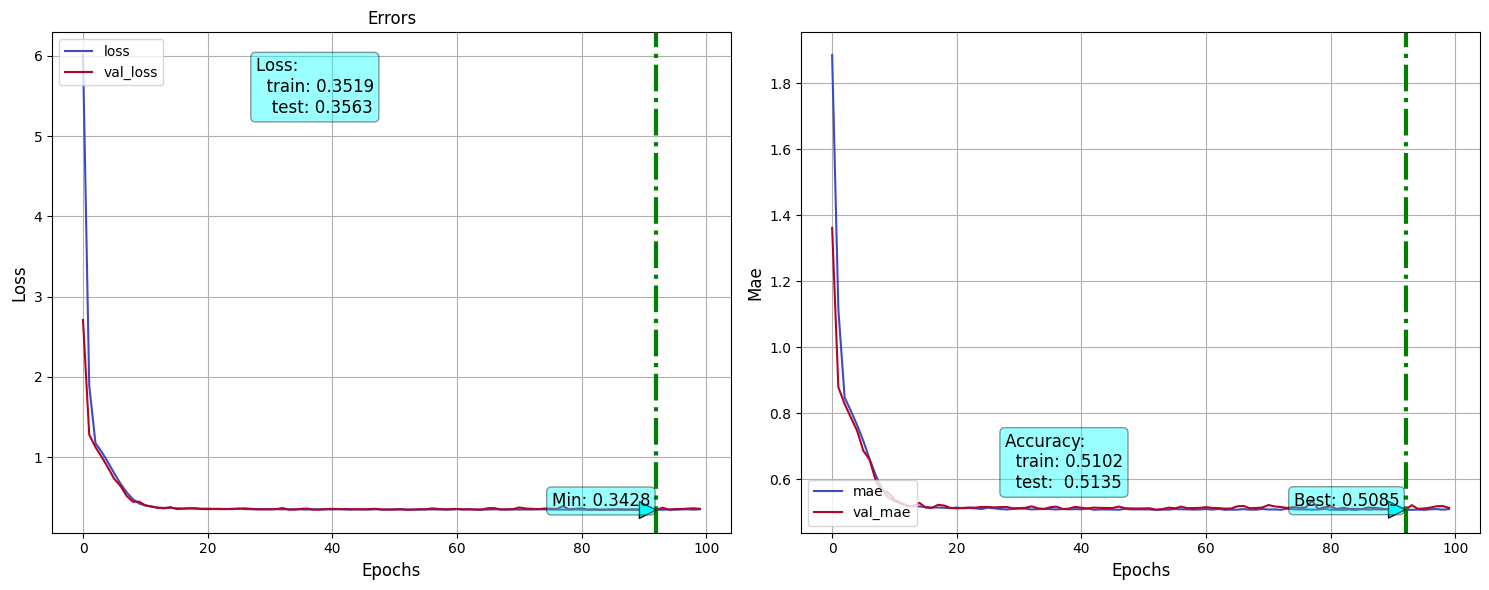

In [27]:
fn_plot_tf_hist(pd.DataFrame(hist_df))

In [28]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'pred' : y_pred[:, 0], 'test' : y_test} )

results_df['y_true'] = y_true_test

27/27 [==============================] - 0s 3ms/step


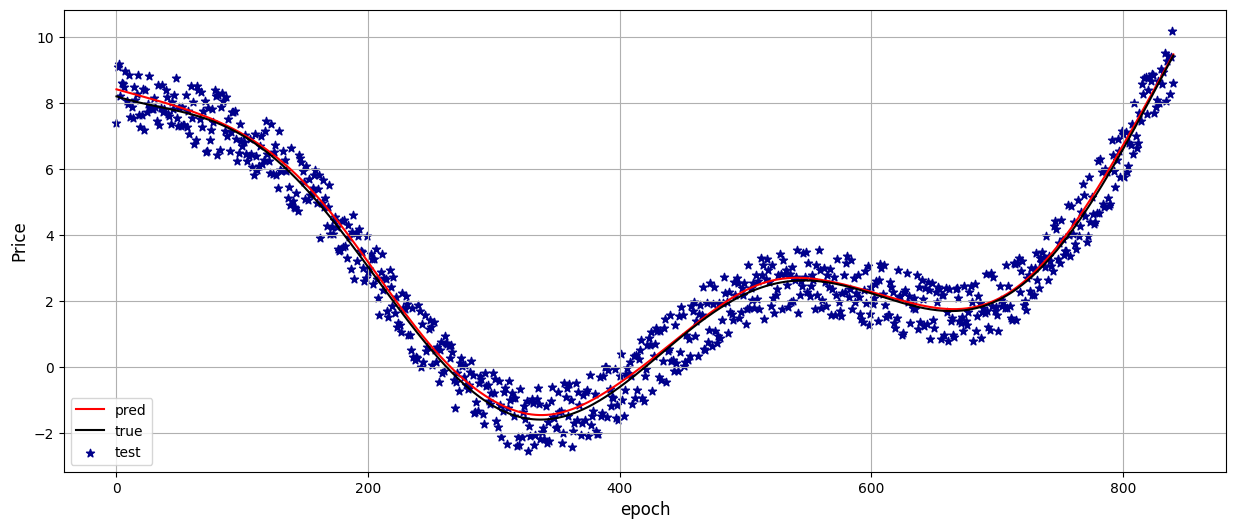

In [29]:
ax = results_df.pred.plot(c = 'r', label = 'pred');
results_df.y_true.plot(c = 'k', ax = ax, label = 'true')

plt.scatter(results_df.index, results_df.test, c='DarkBlue', marker ='*', label = 'test');
ax.set_xlabel("epoch")
ax.set_ylabel("Price")
ax.grid()
plt.legend()
plt.show()